In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

### Batch normalization     
Given a mini-batch of tensors $x_{ci}$ of dimension (S,C,H,W) where $c$ is the channel index and $i$ collectively refers to all other dimensions. 

Let $N=S\times H\times W$. Batch normalization computes the mean and variance of the batch (per channel) according to
  $$
    \begin{align*}
    \mu_c&=\frac{1}{N}\sum_{i=1}^N x_{ci}\\
    \sigma^2_c&=\frac{1}{N}\sum_{i=1}^N \left(x_{ci}-\mu_c\right)^2
    \end{align*}
$$

The normalized inputs are computed as follows:
$$
\begin{align*}
\hat{x}_{ci}=\frac{x_{ic}-\mu_c}{\sqrt{\sigma^2_c+\epsilon}}
\end{align*}
$$

Therefore, for each channel, the $\hat{x}_{ci}$ have zero mean and unit variance. The output of the batch normalization layer is given by
$$
\begin{align*}
y_{ic}=\gamma \hat{x}_{ic}+\beta
\end{align*}
$$
Where $\gamma$ and $\beta$ are **learnable** parameters.

#### Example
- For simplicity we consider a  tensor with a single channel
- Recall that batch normalization is done for each channel independently
- In the example below we create an arbitrary tensor ```a```  of size ```(2,1,22)```
- It represents two samples, each with a single channel representing a 2x2 tensor.


In [2]:
x=torch.tensor([[1,2],[3,4]],dtype=torch.float32).unsqueeze(0)
y=torch.tensor([[5,6],[7,18]],dtype=torch.float32).unsqueeze(0)

a=torch.stack([x,y])
print(list(a.size()))
print(a.numpy())

[2, 1, 2, 2]
[[[[ 1.  2.]
   [ 3.  4.]]]


 [[[ 5.  6.]
   [ 7. 18.]]]]


##### Manual Computation vs Normalization Layer


In [3]:
# Manually 
var=a.var([0,2,3],unbiased=False)
mean=a.mean([0,2,3])
(a-mean)/torch.sqrt(var)

tensor([[[[-0.9512, -0.7509],
          [-0.5507, -0.3504]]],


        [[[-0.1502,  0.0501],
          [ 0.2503,  2.4531]]]])

In [4]:
# using PyTorch BatchNorm2d
with torch.no_grad():
    norm=nn.BatchNorm2d(num_features=1)  
    b=norm(a)
b

tensor([[[[-0.9512, -0.7509],
          [-0.5507, -0.3504]]],


        [[[-0.1502,  0.0501],
          [ 0.2503,  2.4531]]]])

### Convolution Network for CIFAR10

In [5]:
# to ensure reproducibility
seed=9 
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
# use/not use batch normalization
use_BN=True
epochs=50

In [6]:
transform = transforms.ToTensor()
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=512,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class Net(nn.Module):
  def __init__(self,norm_layers=True):
    super().__init__()
    self.norm_layers=norm_layers
    # self.norm1=nn.BatchNorm2d(32)
    # self.norm2=nn.BatchNorm2d(32)
    # self.norm3=nn.BatchNorm2d(64)
    # self.norm4=nn.BatchNorm2d(64)
    self.norm1=nn.Dropout2d(0.5)
    self.norm2=nn.Dropout2d(0.5)
    self.norm3=nn.Dropout2d(0.5)
    self.norm4=nn.Dropout2d(0.5)
    self.relu=nn.ReLU()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
    # input is (*,32,30,30)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
    # input is (*,32,28,28)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,14,14)
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,12,12)
    self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,10,10)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,5,5)
    self.flatten=nn.Flatten()
    # input is (*,64x5x5)
    self.fc1=nn.Linear(in_features=5*5*64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    if self.norm_layers:
      x=self.norm1(x)
    x=self.relu(x)
    x=self.conv2(x)
    if self.norm_layers:
      x=self.norm2(x)
    x=self.relu(x)
    x=self.pool1(x)
    
    x=self.conv3(x)
    if self.norm_layers:
      x=self.norm3(x)
    x=self.relu(x)
    x=self.conv4(x)
    if self.norm_layers:
      x=self.norm4(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
    

In [8]:
def accuracy(model,batch,loss_fn):
    imgs,labels=batch
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,pred=torch.max(outputs,dim=1)
    acc=torch.sum(pred==labels).item()
    loss=loss_fn(outputs,labels)
    return loss,torch.tensor(acc/len(labels))

@torch.no_grad() 
def evaluate(model,loader,loss_fn):
    model.eval()
    # crit is a list of pairs of tensors
    crit=[accuracy(model,batch,loss_fn) for batch in loader]
    crit=torch.tensor(crit)
    m=crit.mean(dim=0)
    loss=m[0]
    acc=m[1]
    return loss,acc

In [9]:
model=Net(norm_layers=use_BN).cuda()
optimizer=Adam(model.parameters())
#optimizer=SGD(model.parameters(),lr=0.5)
loss_fn=nn.CrossEntropyLoss()

In [10]:

from torch.utils.tensorboard import SummaryWriter
import datetime
# To display tensorboard inside the notebook
%load_ext tensorboard
current=datetime.datetime.now()
log_dir = 'logs/tensorboard/' + ('with BN-' if use_BN else 'withou BN-')+current.strftime("%c")
writer=SummaryWriter(log_dir)

In [11]:
class EarlyStopping():
    def __init__(self,patience=4,tolerance=0):
        self.patience=patience
        self.tolerance=tolerance
        self.min_loss=float('inf')
        self.count=0
    def __call__(self,loss):
        if loss<self.min_loss:
            self.count=0
            self.min_loss=loss
            return False
        elif loss>self.min_loss+self.tolerance:
            self.count+=1
            if self.count>self.patience:
                return True
        return False


In [12]:
trigger=True
es=EarlyStopping()
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  epoch_loss=0.
  model.train()
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss=0.9*epoch_loss+0.1*loss.item()
    loop.set_postfix(loss=epoch_loss)
   
  t_loss,t_acc=evaluate(model,loader_train,loss_fn)
  v_loss,v_acc=evaluate(model,loader_test,loss_fn)
  writer.add_scalar("Epoch loss",epoch_loss,epoch)
  writer.add_scalars("loss",{'train':t_loss,'valid':v_loss},epoch)
  writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
  # if es(v_loss) and trigger:
  #   break
  #   print("At epoch={} we should stop. Validation accuracy={}".format(epoch,v_acc))
  #   trigger=False
writer.close()   

Epoch [50/50]: 100%|██████████| 782/782 [00:04<00:00, 180.72it/s, loss=1.24]


In [13]:
%tensorboard --logdir logs/tensorboard

Reusing TensorBoard on port 6006 (pid 323178), started 5 days, 16:33:43 ago. (Use '!kill 323178' to kill it.)

In [14]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=10)
conmat=conmat.cuda()

Defaulting to user installation because normal site-packages is not writeable


In [15]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  correct+=(predicted==labels).sum()
  total+=labels.size()[0]
  conmat.update(predicted,labels)


<AxesSubplot: >

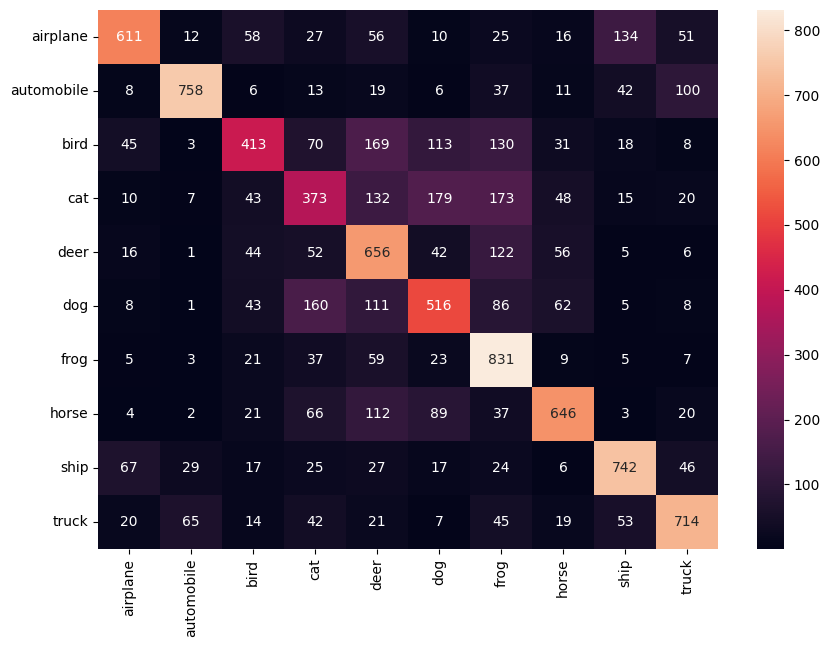

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")

- The rows are the actual images and the columns are the prediction (How can you check?)
- While the prediction accuracy is good albeit not impressive
- From the confusion matrix we find justifications for the inaccuracies
- For example
    - most of the incorrect classifications of automobiles were classified as trucks
    - most of the incorrect classifications of cats/dogs were classified as dogs/cats
    